<a href="https://colab.research.google.com/github/jonad/AnoGan-Pytorch/blob/master/notebooks/AnoGanCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [0]:
manualseed = 999
random.seed(manualseed)

In [8]:
torch.manual_seed(manualseed)

In [0]:
normal_roots = '/content/drive/My Drive/data/normals/'
cancerous_roots = '/content/drive/My Drive/data/cancers/'

In [10]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
image_size = 64
nc = 3
batch_size = 64
workers = 4
n_channels = 3
n_latent_vector = 100
n_generator_feature_map = 64
n_discriminator_feature_map = 64
num_epochs = 5
learning_rate = 0.0002
beta1 = 0.5
ngpu = 1

In [0]:
normal_images = datasets.ImageFolder(root=normal_roots,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [0]:
cancerous_images = datasets.ImageFolder(root=cancerous_roots,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [0]:
dataloader_normal = torch.utils.data.DataLoader(normal_images, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [0]:
dataloader_cancer = torch.utils.data.DataLoader(cancerous_images, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

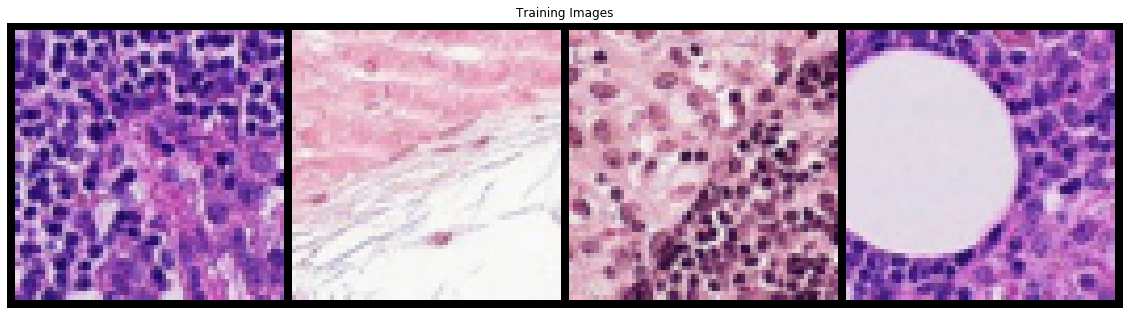

In [20]:
real_batch = next(iter(dataloader_normal))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

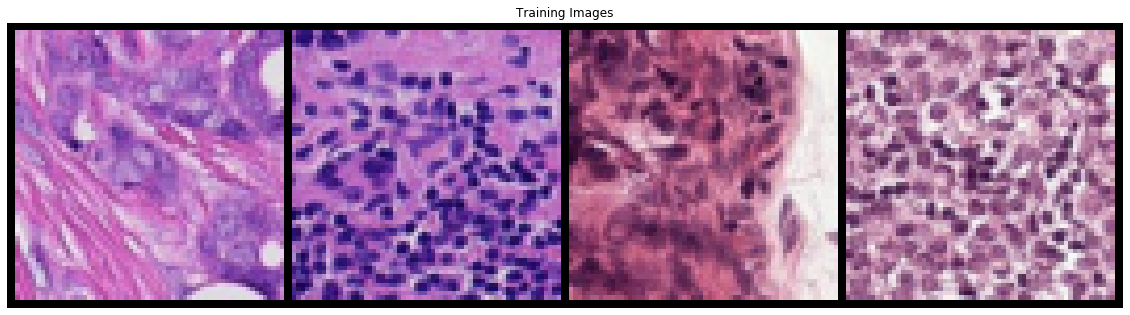

In [21]:
real_batch = next(iter(dataloader_cancer))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [0]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, init_zero_weights=False):
  '''Creates a convolutional layer, with optional batch normalization'''
  layers = []
  conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
  if init_zero_weights:
    conv_layer.weight.data = torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.001
  layers.append(conv_layer)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)

In [0]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, bias=False):
  """Creates a convolutional layer, with optimal batch normalization
  """
  layers = []
  layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias))
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)

### Generator

In [0]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.convT1 = deconv(n_latent_vector, n_generator_feature_map*8, 4, 1, 0)
    self.convT2 = deconv(n_generator_feature_map*8,n_generator_feature_map*4, 4, 2, 1)
    self.convT3 = deconv(n_generator_feature_map*4, n_generator_feature_map*2, 4, 2, 1)
    self.convT4 = deconv(n_generator_feature_map*2, n_generator_feature_map, 4, 2, 1)
    self.output = deconv(n_generator_feature_map, n_channels, 4, 2, 1, batch_norm=False)

  def forward(self, input):
    out = F.relu(self.convT1(input), inplace=True)
    out = F.relu(self.convT2(out), inplace=True)
    out = F.relu(self.convT3(out), inplace=True)
    out = F.relu(self.convT4(out), inplace=True)
    return F.tanh(self.output(out))

In [0]:
netG = Generator(ngpu).to(device)

In [0]:
#handle multi-gpu of desired
if(device.type == 'cuda') and (ngpu > 1):
  netG = nn.DataParallel(netG, list(range(ngpu)))

In [40]:
#apply the weights_init function
netG.apply(weights_init)
print(netG)

Generator(
  (convT1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convT2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convT3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convT4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


## Discriminator

In [0]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu

    self.conv1 = conv(n_channels, n_discriminator_feature_map, 4, 2, 1)
    self.conv2 = conv(n_discriminator_feature_map, n_discriminator_feature_map*2, 4, 2, 1)
    self.conv3 = conv(n_discriminator_feature_map*2, n_discriminator_feature_map*4, 4, 2, 1)
    self.conv4 = conv(n_discriminator_feature_map*4, n_discriminator_feature_map*8, 4, 2, 1)
    self.output = conv(n_discriminator_feature_map*8, 1, 4, 1, 0, batch_norm=False)

  def forward(self, input):
    out = F.leaky_relu(self.conv1(input), inplace=True)
    out = F.leaky_relu(self.conv2(out), inplace=True)
    out = F.leaky_relu(self.conv3(out), inplace=True)
    out = F.leaky_relu(self.conv4(out), inplace=True)
    return F.sigmoid(self.output(out))

In [39]:
# Create the discriminator
netD = Discriminator(ngpu).to(device)

# handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
netD.apply(weights_init)
print(netD)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


## Loss Functions and Optimizers

In [0]:
# Initialize BCELoss Function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, n_latent_vector, 1, 1, device=device)

real_label = 1
fake_label = 0

# setup adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))



In [0]:
checkpoint_dir = '/content/drive/My Drive/data/models/'

In [0]:
def create_dir(directory):
    """Creates a directory if it does not already exist.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)

create_dir(checkpoint_dir)
def checkpoint(iteration, G, D):
    """
    Saves the parameters of the generator G and discriminator D.
    """
    G_path = os.path.join(checkpoint_dir, 'G.pkl')
    D_path = os.path.join(checkpoint_dir, 'D.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

def load_checkpoint(model, checkpoint_name):
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, checkpoint_name)))

## Training

In [0]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print(f'Starting Training Loop ... ')
for epoch in range(num_epochs*25):
  for i, data in enumerate(dataloader_normal,0):
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    real_data = data[0].to(device)
    b_size = real_data.size(0)
    label = torch.full((b_size, ), real_label, device=device)
    # Forward pass
    output = netD(real_data).view(-1)
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    ## Train with all-fake batch
    noise = torch.randn(b_size, n_latent_vector, 1, 1, device=device)
    fake = netG(noise)
    label.fill_(fake_label)
    output = netD(fake.detach()).view(-1)
    errD_fake = criterion(output, label)
    # calculate the gradients for the batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)
    output = netD(fake).view(-1)
    errG = criterion(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()
    # Output training stats
    if i %100 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader_normal),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader_normal)-1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
    iters += 1
        
        
    
      


Starting Training Loop ... 


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0/5][0/2500]	Loss_D: 0.8290	Loss_G: 5.5332	D(x): 0.9669	D(G(z)): 0.5180 / 0.0083
[0/5][100/2500]	Loss_D: 0.6165	Loss_G: 9.5641	D(x): 0.9882	D(G(z)): 0.3931 / 0.0002
[0/5][200/2500]	Loss_D: 0.0225	Loss_G: 6.9301	D(x): 0.9920	D(G(z)): 0.0143 / 0.0016
[0/5][300/2500]	Loss_D: 0.3374	Loss_G: 5.5865	D(x): 0.9620	D(G(z)): 0.2563 / 0.0046
[0/5][400/2500]	Loss_D: 0.7293	Loss_G: 5.6607	D(x): 0.7880	D(G(z)): 0.3166 / 0.0049
[0/5][500/2500]	Loss_D: 0.2474	Loss_G: 4.3100	D(x): 0.9598	D(G(z)): 0.1706 / 0.0174
[0/5][600/2500]	Loss_D: 0.1350	Loss_G: 5.2560	D(x): 0.9086	D(G(z)): 0.0275 / 0.0075
[0/5][700/2500]	Loss_D: 0.8938	Loss_G: 4.5471	D(x): 0.5319	D(G(z)): 0.0136 / 0.0131
[0/5][800/2500]	Loss_D: 0.3183	Loss_G: 6.7084	D(x): 0.9320	D(G(z)): 0.2103 / 0.0014
[0/5][900/2500]	Loss_D: 0.1965	Loss_G: 5.7513	D(x): 0.8429	D(G(z)): 0.0198 / 0.0043
[0/5][1000/2500]	Loss_D: 0.2329	Loss_G: 2.9394	D(x): 0.8773	D(G(z)): 0.0925 / 0.0563
[0/5][1100/2500]	Loss_D: 0.8184	Loss_G: 3.4640	D(x): 0.5625	D(G(z)): 0.1818 /

## Results

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# ToDo
 ## 1 - Inverse Mapping network
 ## 2 - Residual Loss function
 ## 3 - Discrimination Loss function
 ## 4 - Anomalies detection function